In [ ]:
import pandas as pd
import numpy as np
import math
import os
import glob
import zipfile
import concurrent.futures
from datetime import timedelta, datetime
import warnings

warnings.filterwarnings('ignore')

# Set the path to the Excel file containing survey results
survey_results_path = r'Data\SurveyResults.xlsx'

# Read the survey results from Excel and process date-time columns
survey_data = pd.read_excel(survey_results_path, usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'], dtype={'ID': str})
survey_data['Stress level'].replace('na', np.nan, inplace=True)
survey_data.dropna(inplace=True)

survey_data['Start datetime'] = pd.to_datetime(survey_data['date'].map(str) + ' ' + survey_data['Start time'].map(str))
survey_data['End datetime'] = pd.to_datetime(survey_data['date'].map(str) + ' ' + survey_data['End time'].map(str))
survey_data.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)

# Convert SurveyResults.xlsx to GMT-00:00
daylight = pd.to_datetime(datetime(2020, 11, 1, 0, 0))

# Split survey data into two parts based on daylight saving time
survey_data_part1 = survey_data[survey_data['End datetime'] <= daylight].copy()
survey_data_part1['Start datetime'] = survey_data_part1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
survey_data_part1['End datetime'] = survey_data_part1['End datetime'].apply(lambda x: x + timedelta(hours=5))

survey_data_part2 = survey_data.loc[survey_data['End datetime'] > daylight].copy()
survey_data_part2['Start datetime'] = survey_data_part2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
survey_data_part2['End datetime'] = survey_data_part2['End datetime'].apply(lambda x: x + timedelta(hours=6))

survey_data = pd.concat([survey_data_part1, survey_data_part2], ignore_index=True)
survey_data['duration'] = survey_data['End datetime'] - survey_data['Start datetime']

# Define a function to calculate duration in minutes
def calculate_duration_minutes(duration):
    return duration.seconds / 60

survey_data['duration_minutes'] = survey_data['duration'].apply(calculate_duration_minutes)

survey_data.reset_index(drop=True, inplace=True)

# To measure the time of execution
# %%time

# Get all the folders inside the specified path
data_folders = glob.glob(os.path.join(r"Data\*"))

file_count = 0
# Creating a new DataFrame to hold all the data
final_data = pd.DataFrame()

# Loop through all the folders to extract the files
for folder_index in range(len(data_folders)):
    folder = data_folders[folder_index]
    # Get the list of zip files in the folder
    zip_files = glob.glob(os.path.join(folder, '*.zip'))

    # Loop through each zip file to unzip and process the data
    for zip_file in zip_files:
        with zipfile.ZipFile(zip_file) as zf:
            zf.extractall(folder)

        # Read and process individual CSV files
        ACC = pd.read_csv(os.path.join(folder, 'ACC.csv'))
        BVP = pd.read_csv(os.path.join(folder, 'BVP.csv'))
        EDA = pd.read_csv(os.path.join(folder, 'EDA.csv'))
        HR = pd.read_csv(os.path.join(folder, 'HR.csv'))
        TEMP = pd.read_csv(os.path.join(folder, 'TEMP.csv'))

        # Function to process DataFrame with timestamp
        def process_df_with_timestamp(df):
            start_timestamp = df.iloc[0, 0]
            sample_rate = df.iloc[1, 0]
            new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
            new_df['datetime'] = [(start_timestamp + i / sample_rate) for i in range(len(new_df))]
            return new_df

        ACC = process_df_with_timestamp(ACC)
        BVP = process_df_with_timestamp(BVP)
        EDA = process_df_with_timestamp(EDA)
        HR = process_df_with_timestamp(HR)
        TEMP = process_df_with_timestamp(TEMP)

        # Rename the columns
        ACC.rename({'ACC_X': 'X', 'ACC_Y': 'Y', 'ACC_Z': 'Z'}, axis=1, inplace=True)
        BVP.rename({'BVP': 'BVP'}, axis=1, inplace=True)
        EDA.rename({'EDA': 'EDA'}, axis=1, inplace=True)
        HR.rename({'HR': 'HR'}, axis=1, inplace=True)
        TEMP.rename({'TEMP': 'TEMP'}, axis=1, inplace=True)

        # Merge the DataFrames
        new_data = ACC.merge(EDA, on='datetime', how='outer')
        new_data = new_data.merge(TEMP, on='datetime', how='outer')
        new_data = new_data.merge(HR, on='datetime', how='outer')

        # Fill null values by forward and backward fill
        new_data.fillna(method='ffill', inplace=True)
        new_data.fillna(method='bfill', inplace=True)
        new_data.reset_index(inplace=True, drop=True)

        # Append and concatenate the final merged files
        if folder_index == 0:
            final_data = new_data.append(final_data)
        else:
            final_data = pd.concat([final_data, new_data], ignore_index=True)
        file_count += 1

    file_count = 0

# Convert the 'datetime' column in 'final_data' to datetime64 type
final_data['datetime'] = pd.to_datetime(final_data['datetime'])

# Convert the 'id' column in 'final_data' and 'ID' column in 'survey_data' to string data type
final_data['id'] = final_data['id'].astype(str)
survey_data['ID'] = survey_data['ID'].astype(str)

# Define a function to label rows in 'final_data' as 1 or 0 based on the 'datetime' column
def label_data(row_datetime):
    max_datetime = survey_data['End datetime'].max()
    if row_datetime >= max_datetime:
        return 1
    else:
        return 0

# Apply the 'label_data' function to the 'datetime' column in 'final_data' and assign the result to a new 'Label' column
final_data['Label'] = final_data['datetime'].apply(label_data)

# Save the final DataFrame to a CSV file
final_data.to_csv("final_data.csv", index=False)


In [34]:
data = pd.read_csv('final_data.csv')

In [35]:
data.head()

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0


In [23]:
len(data)

11509051

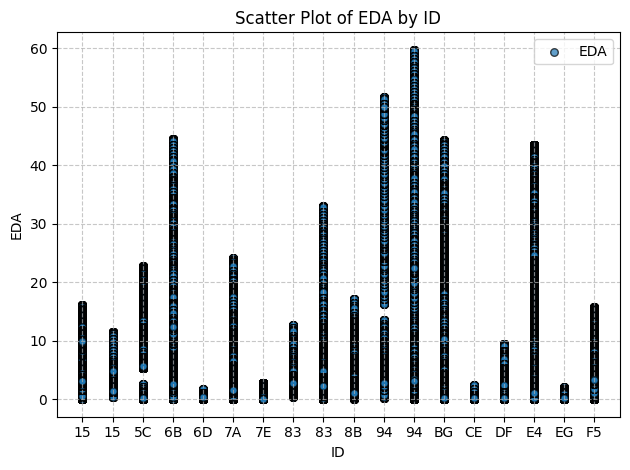

In [75]:
import matplotlib.pyplot as plt

# Create a mapping dictionary for the ids
unique_ids = data['id'].unique()
id_map = {id_val: i + 1 for i, id_val in enumerate(unique_ids)}

# Create a new column with the mapped values
data['id_num'] = data['id'].map(id_map)


# Create a scatter plot with the x-axis scaled to the unique id_num values
plt.scatter(data['id_num'], data['EDA'], s=30, edgecolors='black', alpha=0.7, label='EDA')

# Set the x-axis tick locations and labels
plt.xticks(range(1, len(unique_ids) + 1), unique_ids)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add axis labels and a title
plt.xlabel('ID')
plt.ylabel('EDA')
plt.title('Scatter Plot of EDA by ID')

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust spacing
plt.show()


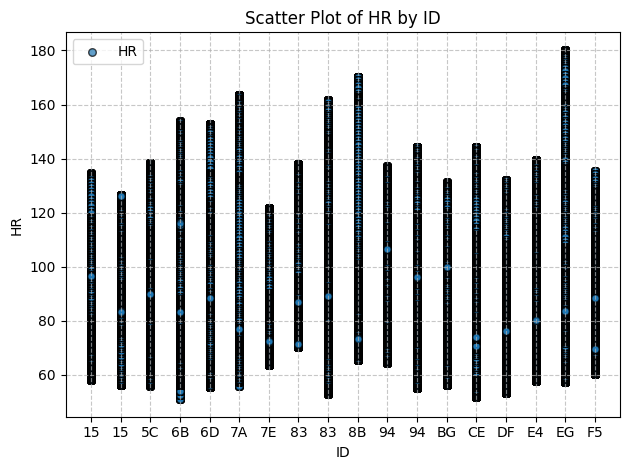

In [29]:
import matplotlib.pyplot as plt

# Create a scatter plot with the x-axis scaled to the unique id_num values
plt.scatter(data['id_num'], data['HR'], s=30, edgecolors='black', alpha=0.7, label='HR')

# Set the x-axis tick locations and labels
plt.xticks(range(1, len(unique_ids) + 1), unique_ids)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add axis labels and a title
plt.xlabel('ID')
plt.ylabel('HR')
plt.title('Scatter Plot of HR by ID')

# Show legend
plt.legend()

# Show the plot
plt.tight_layout() 
plt.show()


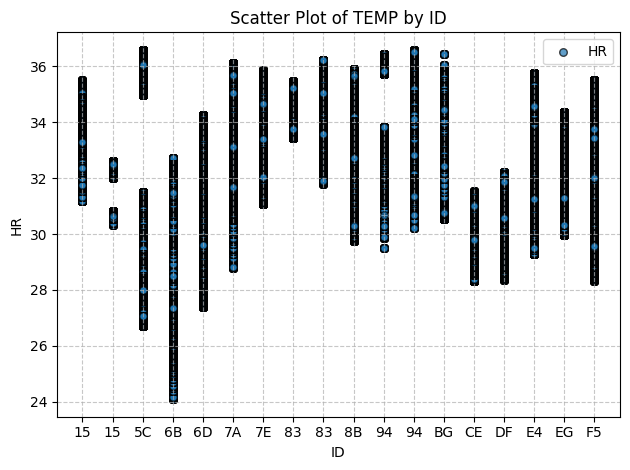

In [30]:
import matplotlib.pyplot as plt

# Create a scatter plot with the x-axis scaled to the unique id_num values
plt.scatter(data['id_num'], data['TEMP'], s=30, edgecolors='black', alpha=0.7, label='HR')

# Set the x-axis tick locations and labels
plt.xticks(range(1, len(unique_ids) + 1), unique_ids)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add axis labels and a title
plt.xlabel('ID')
plt.ylabel('HR')
plt.title('Scatter Plot of TEMP by ID')

# Show legend
plt.legend()

# Show the plot
plt.tight_layout() 
plt.show()


In [32]:
# Check for missing values
print(data.isnull().sum())

X           0
Y           0
Z           0
EDA         0
HR          0
TEMP        0
id          0
datetime    0
label       0
id_num      0
dtype: int64


In [36]:
# Check for duplicates
print(data.duplicated().sum())

105606


<AxesSubplot: >

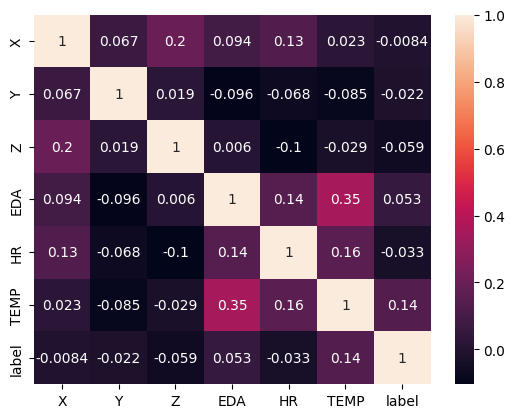

In [38]:
import seaborn as sns

sns.heatmap(data.corr(),annot = True)

array([[<AxesSubplot: title={'center': 'X'}>,
        <AxesSubplot: title={'center': 'Y'}>,
        <AxesSubplot: title={'center': 'Z'}>],
       [<AxesSubplot: title={'center': 'EDA'}>,
        <AxesSubplot: title={'center': 'HR'}>,
        <AxesSubplot: title={'center': 'TEMP'}>],
       [<AxesSubplot: title={'center': 'label'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

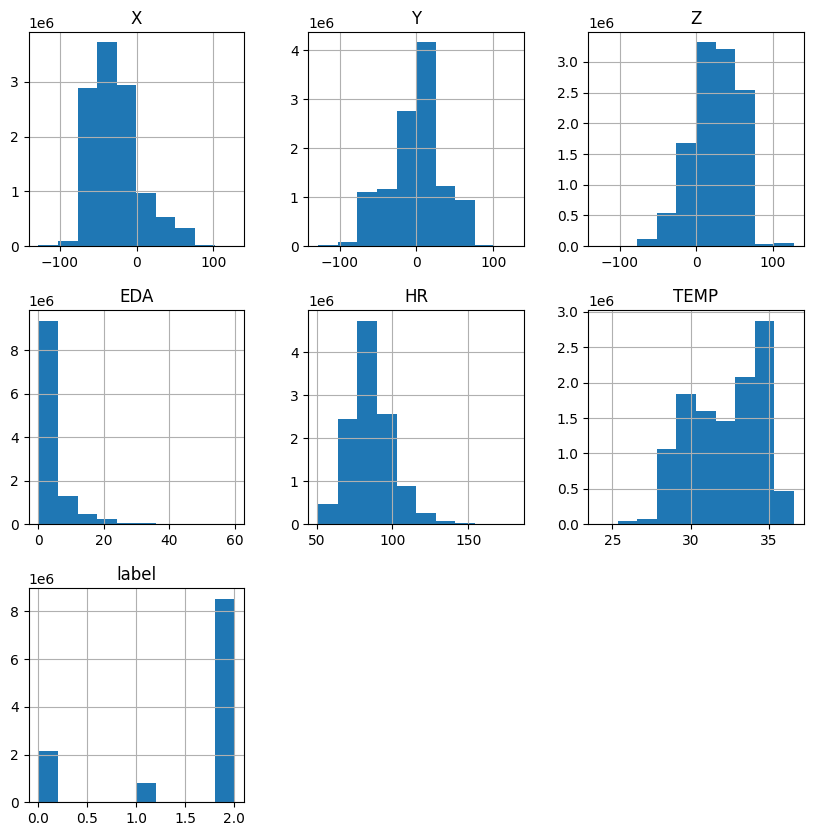

In [39]:
data.hist(figsize = (10,10))

In [40]:
from sklearn.model_selection import train_test_split

In [46]:
# Sort the data by the 'datetime' column to ensure temporal order
data_sorted = data.sort_values('datetime')

# Calculate the index for splitting the data
split_index = int(len(data_sorted) * 0.8)  # Use 80% for training

# Split the data into training and testing sets
train_data = data_sorted.iloc[:split_index]
test_data = data_sorted.iloc[split_index:]

# Extract X and y from the training and testing sets
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

# Output the shapes of the split data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(9207240, 8) (9207240,) (2301811, 8) (2301811,)


In [48]:
import pandas as pd

# Find the row(s) with non-numeric values in each column
for column in data.columns:
    non_numeric_mask = pd.to_numeric(data[column], errors='coerce').isna()
    non_numeric_rows = data[non_numeric_mask]
    if not non_numeric_rows.empty:
        print(f"Non-numeric values in column '{column}':")
        print(non_numeric_rows)


Non-numeric values in column 'id':
             X     Y      Z        EDA     HR   TEMP  id  \
309131   -22.0 -43.0  127.0  21.941885  82.67  36.49  5C   
309132   -22.0 -43.0  127.0  21.941885  82.67  36.49  5C   
309133   -22.0 -43.0  127.0  21.941885  82.67  36.49  5C   
309134   -22.0 -43.0  127.0  21.941885  82.67  36.49  5C   
309135   -22.0 -43.0  127.0  21.941885  82.67  36.49  5C   
...        ...   ...    ...        ...    ...    ...  ..   
11509046 -16.0 -56.0   24.0   3.386070  88.37  33.77  F5   
11509047  -8.0 -50.0   27.0   3.386070  88.37  33.77  F5   
11509048 -28.0 -36.0   28.0   3.386070  88.37  33.77  F5   
11509049 -29.0 -29.0   30.0   3.386070  88.37  33.77  F5   
11509050 -22.0 -24.0   29.0   3.374543  88.33  33.75  F5   

                               datetime  label  
309131    2020-04-14 22:31:00.000000000    1.0  
309132    2020-04-14 22:31:00.031249920    1.0  
309133    2020-04-14 22:31:00.062500096    1.0  
309134    2020-04-14 22:31:00.093750016    1.0  

In [49]:
data['id'] = data['id'].astype('category')


In [50]:
data['datetime'] = pd.to_datetime(data['datetime'])


In [62]:
from sklearn.preprocessing import StandardScaler

# Assuming you have already split the data into X_train, y_train, X_test, and y_test

# Drop the 'id' and 'datetime' columns from the feature sets
X_train_features = X_train.drop(['id', 'datetime'], axis=1)
X_test_features = X_test.drop(['id', 'datetime'], axis=1)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training features
X_train_scaled = scaler.fit_transform(X_train_features)

# Transform the testing features using the same scaler used on the training data
X_test_scaled = scaler.transform(X_test_features)


# Logistic Regression Algorithm

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [59]:
Logistic_regression = LogisticRegression(random_state=0).fit(X_train_scaled, y_train)

y_pred_LR = Logistic_regression.predict(X_test_scaled)
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    243847
         2.0       0.89      0.95      0.92   2057964

    accuracy                           0.85   2301811
   macro avg       0.44      0.47      0.46   2301811
weighted avg       0.79      0.85      0.82   2301811



<AxesSubplot: >

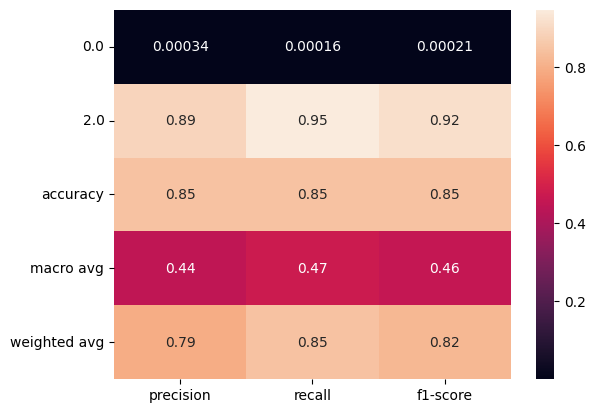

In [60]:
model1 = classification_report(y_test, y_pred_LR,output_dict=True)

sns.heatmap(pd.DataFrame(model1).iloc[:-1, :].T, annot=True)

# Naive Bayes Algorithm

In [70]:
from sklearn.naive_bayes import GaussianNB

In [71]:
Naive_bayes = GaussianNB()
Naive_bayes.fit(X_train_scaled, y_train)

y_pred_NB = Naive_bayes.predict(X_test_scaled)
print(classification_report(y_test, y_pred_NB))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    243847
         1.0       0.00      0.00      0.00         0
         2.0       0.88      0.84      0.86   2057964

    accuracy                           0.75   2301811
   macro avg       0.29      0.28      0.29   2301811
weighted avg       0.78      0.75      0.77   2301811



<AxesSubplot: >

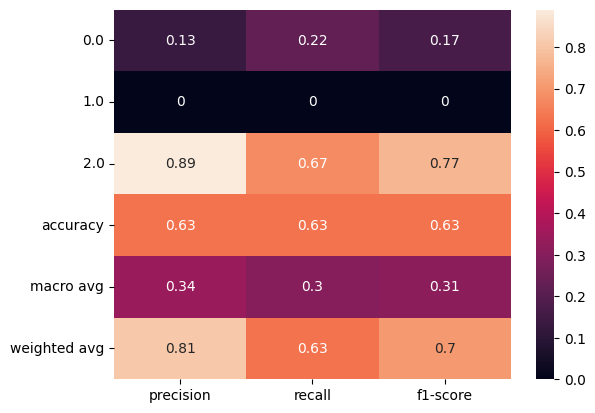

In [72]:
model2 = classification_report(y_test, y_pred_NB,output_dict=True)

sns.heatmap(pd.DataFrame(result_KN).iloc[:-1, :].T, annot=True)